In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import os
from tqdm import tqdm
import json
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

# Loading data

In [2]:
train_json = '../input/region-proposals-of-crop-weed-dataset/train.json'
test_json = '../input/region-proposals-of-crop-weed-dataset/test.json'
images_path = '../input/crop-and-weed-detection-data-with-bounding-boxes/agri_data/data/'
model_path  = '../input/rcnn-training-part-1-finetuning/RCNN_crop_weed_classification_model.h5'
label_csv = '../input/convert-yolo-labels-to-pascalvoc-format/pascal_voc_format.csv'
negative_ex_path = '../input/rcnn-data-preprocessing-part-2/Train/background/'

## Loading pre generated region proposals and Negative examples

In [3]:
with open(train_json,'r') as train:
    train_region = json.load(train)

In [4]:
with open(test_json,'r') as test:
    test_region = json.load(test)

In [5]:
train_images_list = list(train_region.keys())
test_images_list = list(test_region.keys())

In [6]:
print(len(train_images_list))
print(len(test_images_list))

1000
300


## Loading object annotation

In [7]:
labels = pd.read_csv(label_csv)
labels.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,agri_0_9354.jpeg,512,512,weed,63,120,425,442
1,agri_0_9354.jpeg,512,512,weed,0,1,180,148
2,agri_0_7574.jpeg,512,512,crop,95,167,453,469
3,agri_0_8960.jpeg,512,512,weed,52,76,422,353
4,agri_0_417.jpeg,512,512,weed,7,75,511,411


## Loading pretrained CNN model

In [8]:
model = tf.keras.models.load_model(model_path)

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## loading model without last two Fully connected layers

In [10]:
model_without_last_2FC = tf.keras.models.Model(model.inputs,model.layers[-5].output)

In [11]:
model_without_last_2FC.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

# Extracting features from ground truth labeled images

When we pass image from model it will return (1,4096) size feature vector

In [12]:
train_features = []

test_features = []


for index in tqdm(range(len(labels))):
    id = labels.loc[index,'filename']
    img = cv2.imread(images_path + id)
    rgb_img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    xmin,ymin,xmax,ymax = int(labels.loc[index,'xmin']) ,int(labels.loc[index,'ymin']),int(labels.loc[index,'xmax']),int(labels.loc[index,'ymax'])

    resized = cv2.resize(rgb_img[ymin:ymax,xmin:xmax,:],(224,224))

    feature_of_img = model_without_last_2FC.predict(resized.reshape(1,224,224,3)/255)
    
    if id in train_images_list:
        
        train_features.append([feature_of_img,labels.loc[index,'class']])
        
    else:
        test_features.append([feature_of_img,labels.loc[index,'class']])
      

100%|██████████| 2072/2072 [01:31<00:00, 22.54it/s]


In [13]:
print(len(train_features))

print(len(test_features))


1637
435


# Extracting features from Negative examples

In [14]:
for index,img in tqdm(enumerate(os.listdir(negative_ex_path)[:5000])):  #only extracting for 10,000 images
    img = cv2.imread(negative_ex_path + img )
    rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    #images already in (224,224,3)
    feature_of_img = model_without_last_2FC.predict(rgb.reshape(1,224,224,3)/255)
    if index<3500:
        train_features.append([feature_of_img,'background'])
    else:
        test_features.append([feature_of_img,'background'])

5000it [03:22, 24.67it/s]


# Preparing data for SVM

In [15]:
import random
random.shuffle(train_features)

In [16]:
X_train = np.array([x[0] for x in train_features])
X_train = X_train.reshape(-1,4096)

In [17]:
X_train.shape

(5137, 4096)

In [18]:
y_train = [x[1] for x in train_features]
y_train = np.array(y_train).reshape(-1,1)

In [19]:
y_train.shape

(5137, 1)

In [20]:
X_test = np.array([x[0] for x in test_features])
X_test = X_test.reshape(-1,4096)

In [21]:
y_test = [x[1] for x in test_features]
y_test = np.array(y_test).reshape(-1,1)

# SVM Training

In [22]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [23]:
svm_model_linear = SVC(kernel = 'linear', C = 1,probability=True).fit(X_train, y_train) 
svm_predictions = svm_model_linear.predict(X_test)

In [24]:
accuracy = svm_model_linear.score(X_test, y_test)

In [25]:
accuracy

0.9648578811369509

In [26]:
cm = confusion_matrix(y_test, svm_predictions) 

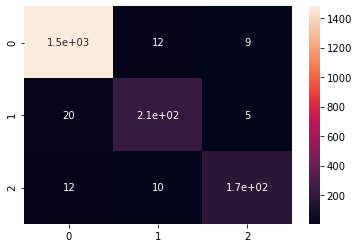

In [27]:
sns.heatmap(cm,annot=True)

# Check on some images

**Crop Image Prediction**

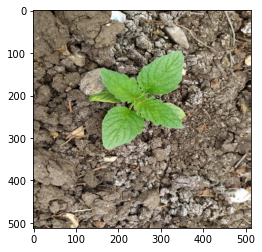

In [28]:
img = cv2.imread(images_path+'agri_0_1026.jpeg')
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

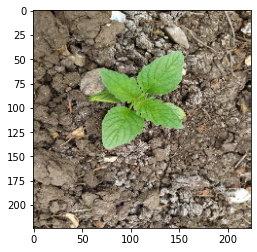

In [29]:
resized = cv2.resize(rgb,(224,224))
plt.imshow(resized)

In [30]:
svm_model_linear.predict(model_without_last_2FC.predict(resized.reshape(1,224,224,3)/255))

array(['crop'], dtype='<U10')

In [31]:
svm_model_linear.classes_


array(['background', 'crop', 'weed'], dtype='<U10')

In [32]:
svm_model_linear.predict_proba(model_without_last_2FC.predict(resized.reshape(1,224,224,3)/255))

array([[0.01052838, 0.87226468, 0.11720694]])

2nd Home Test Image

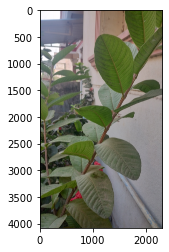

In [33]:
img = cv2.imread('/kaggle/input/crop-img/crop_img3.jpg')
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

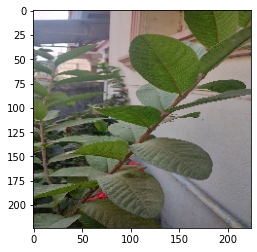

In [34]:
resized = cv2.resize(rgb,(224,224))
plt.imshow(resized)

In [35]:
svm_model_linear.predict(model_without_last_2FC.predict(resized.reshape(1,224,224,3)/255))


array(['crop'], dtype='<U10')

In [36]:
svm_model_linear.classes_

array(['background', 'crop', 'weed'], dtype='<U10')

In [37]:
svm_model_linear.predict_proba(model_without_last_2FC.predict(resized.reshape(1,224,224,3)/255))

array([[0.01310194, 0.92918663, 0.05771143]])

**Background Image Prediction**

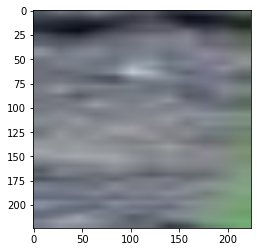

In [38]:
img = cv2.imread(negative_ex_path + os.listdir(negative_ex_path)[45] )
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

In [39]:
feature_of_img = model_without_last_2FC.predict(rgb.reshape(1,224,224,3)/255)

In [40]:
svm_model_linear.predict(feature_of_img)

array(['background'], dtype='<U10')

In [41]:
svm_model_linear.classes_

array(['background', 'crop', 'weed'], dtype='<U10')

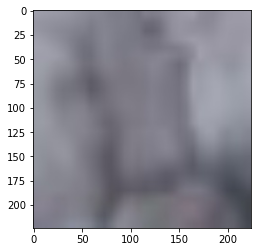

In [42]:
img = cv2.imread(negative_ex_path + os.listdir(negative_ex_path)[6] )
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

In [43]:
feature_of_img = model_without_last_2FC.predict(rgb.reshape(1,224,224,3)/255)
svm_model_linear.predict(feature_of_img)

array(['background'], dtype='<U10')

**Weed Image Prediction**

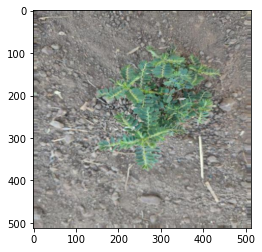

In [44]:
img = cv2.imread(images_path+'agri_0_1024.jpeg')
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

In [45]:
resized = cv2.resize(rgb,(224,224))

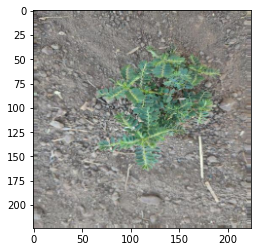

In [46]:
plt.imshow(resized)

In [47]:
svm_model_linear.predict_proba(model_without_last_2FC.predict(resized.reshape(1,224,224,3)/255))

array([[0.00819638, 0.01497857, 0.97682506]])

In [48]:
svm_model_linear.predict(model_without_last_2FC.predict(resized.reshape(1,224,224,3)/255))

array(['weed'], dtype='<U10')

2nd Image

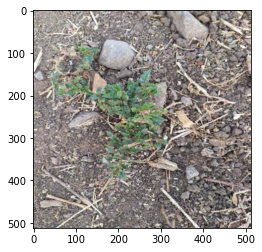

In [49]:
img = cv2.imread(images_path+'agri_0_1068.jpeg')
rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(rgb)

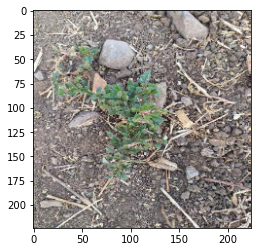

In [50]:
resized = cv2.resize(rgb,(224,224))
plt.imshow(resized)

In [51]:
svm_model_linear.predict_proba(model_without_last_2FC.predict(resized.reshape(1,224,224,3)/255))

array([[0.00310404, 0.03237579, 0.96452017]])

In [52]:
svm_model_linear.predict(model_without_last_2FC.predict(resized.reshape(1,224,224,3)/255))

array(['weed'], dtype='<U10')

# Saving SVM model

In [53]:
import pickle

with open('svm_classifier.pkl','wb') as svm_model:
    pickle.dump(svm_model_linear , svm_model)